In [138]:

import os
import pandas as pd
import numpy as np
import netCDF4
import datetime as dt
import matplotlib.pyplot as plt
import urllib.request
from scipy.spatial import KDTree

PROJ_ROOT = os.path.join(os.pardir)

In [39]:
rm = os.path.join(PROJ_ROOT, 
                         'data',
                        'raw-data',
                         'acpcp.2011.nc')

nc=netCDF4.Dataset(rm)

nar_path = os.path.join(PROJ_ROOT, 
                         'data',
                        'raw-data',
                        'narr_data',
                       '')

In [53]:
df=pd.read_csv(os.path.join(PROJ_ROOT, 
                         'data',
                        'processed',
                         'lc_pol_merged_data.csv'), parse_dates=['new_date'],usecols=['new_date'])

In [132]:
loc_df=pd.read_csv(os.path.join(PROJ_ROOT, 
                         'data',
                        'processed',
                         'lc_pol_merged_data.csv'),usecols=['Longitude','Latitude'])

In [63]:
start_yr=df.new_date.min().year
end_yr=df.new_date.max().year
daterange = df.iloc[:,0].astype(str)

print(start_yr, end_yr)

1998 2020


In [66]:
long_range = (-80.44707800,-74.83524400)
lat_range = (36.73004000,42.80672000 )

'..\\data\\raw-data\\narr_data\\'

In [49]:
fid=urllib.request.urlretrieve("ftp://ftp.cdc.noaa.gov/Datasets/NARR/monolevel/air.2m."+str(start_yr)+".nc",
                               nar_path+"air.2m."+str(start_yr)+".nc") 
nc_fid = netCDF4.Dataset(fid[0],'r')
narrlats = nc_fid.variables['lat'][:].data
narrlons = nc_fid.variables['lon'][:].data

In [72]:
for i in range(start_yr, end_yr+1):
    print(i)

1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [75]:
#Define a function to extract just the Chesapeake Bay region 

def extractCB(vardata,latdata,londata,latrange,lonrange):
  latlon_inds=np.where((latdata>latrange[0]) & (latdata<latrange[1])
                       & (londata>lonrange[0]) & (londata<lonrange[1]))
  var_subset=vardata[:,latlon_inds[0].min():latlon_inds[0].max(),latlon_inds[1].min():latlon_inds[1].max()]
  lat_subset=latdata[latlon_inds[0].min():latlon_inds[0].max(),latlon_inds[1].min():latlon_inds[1].max()]
  lon_subset=londata[latlon_inds[0].min():latlon_inds[0].max(),latlon_inds[1].min():latlon_inds[1].max()]
  return lat_subset, lon_subset, var_subset

# Define a function to loop through and return the subsetted area at the times of interest

def narr_subset_variable(file_prefix,varname,start_year,end_year,narr_lats,narr_lons,latrange,lonrange): 
  for i in range(start_year,end_year+1):
    fid=urllib.request.urlretrieve("ftp://ftp.cdc.noaa.gov/Datasets/NARR/monolevel/"+file_prefix+"."+str(i)+".nc",
                                   "/tmp/"+file_prefix+"."+str(i)+".nc") 
#     fid=urllib.request.urlretrieve("ftp://ftp.cdc.noaa.gov/Datasets/NARR/monolevel/"+file_prefix+"."+str(i)+".nc",
#                                    "/tmp/"+file_prefix+"."+str(i)+".nc") 
    nc_fid = netCDF4.Dataset(fid[0])
    if i==start_year:
      time = nc_fid.variables['time'][:].data
      subset_time = [dt.datetime(1800,1,1) + dt.timedelta(hours=t) for t in time]
      vartmp = nc_fid.variables[varname][:]  # shape is time, lat, lon as shown above
      latsubset, lonsubset, varsubset=extractCB(vartmp.data,narr_lats,narr_lons,latrange,lonrange)
      print(i,varname,'data imported','\n')
    else:
      time = nc_fid.variables['time'][:].data
      dt_tmp = [dt.datetime(1800,1,1) + dt.timedelta(hours=t) for t in time]
      subset_time = np.append(subset_time,dt_tmp)
      vartmp = nc_fid.variables[varname][:]  # shape is time, lat, lon as shown above
      _, _, varsubsettmp=extractCB(vartmp.data,narr_lats,narr_lons,latrange,lonrange)
      varsubset=np.vstack((varsubset,varsubsettmp))
      print(i,varname,'data imported','\n')
  return varsubset, subset_time, latsubset, lonsubset

In [79]:
filesprefix = 'air.2m'
varnames = 'air'
airsubset, time_narr_import, lat_subset, long_subset = narr_subset_variable(filesprefix,
                                                                           varnames,
                                                                           start_yr,
                                                                           end_yr,
                                                                           narrlats,
                                                                           narrlons,
                                                                           lat_range,
                                                                           long_range)

1998 air data imported 

1999 air data imported 

2000 air data imported 

2001 air data imported 

2002 air data imported 

2003 air data imported 

2004 air data imported 

2005 air data imported 

2006 air data imported 

2007 air data imported 

2008 air data imported 

2009 air data imported 

2010 air data imported 

2011 air data imported 

2012 air data imported 

2013 air data imported 

2014 air data imported 

2015 air data imported 

2016 air data imported 

2017 air data imported 

2018 air data imported 

2019 air data imported 

2020 air data imported 



In [84]:
# from collections import defaultdict

# var_data = defaultdict(list)

# filesprefix = ['apcp','uwnd.10m','vwnd.10m','rhum','lcdc','ssrun','air.sfc']
# varnames = ['apcp','uwnd','vwnd','rhum','lcdc','ssrun','air']
filesprefix = ['rhum.2m','lcdc','ssrun','air.sfc']
varnames = ['rhum','lcdc','ssrun','air']



for fileprefix, varname in zip(filesprefix,varnames):
    cvarsubset, _, _, _ = narr_subset_variable(fileprefix,
                                              varname,
                                              start_yr,
                                              end_yr,
                                              narrlats,
                                              narrlons,
                                              lat_range,
                                              long_range)
    
    var_data[varname]=cvarsubset


1998 rhum data imported 

1999 rhum data imported 

2000 rhum data imported 

2001 rhum data imported 

2002 rhum data imported 

2003 rhum data imported 

2004 rhum data imported 

2005 rhum data imported 

2006 rhum data imported 

2007 rhum data imported 

2008 rhum data imported 

2009 rhum data imported 

2010 rhum data imported 

2011 rhum data imported 

2012 rhum data imported 

2013 rhum data imported 

2014 rhum data imported 

2015 rhum data imported 

2016 rhum data imported 

2017 rhum data imported 

2018 rhum data imported 

2019 rhum data imported 

2020 rhum data imported 

1998 lcdc data imported 

1999 lcdc data imported 

2000 lcdc data imported 

2001 lcdc data imported 

2002 lcdc data imported 

2003 lcdc data imported 

2004 lcdc data imported 

2005 lcdc data imported 

2006 lcdc data imported 

2007 lcdc data imported 

2008 lcdc data imported 

2009 lcdc data imported 

2010 lcdc data imported 

2011 lcdc data imported 

2012 lcdc data imported 

2013 lcdc da

C:\Users\Bryan\Anaconda3\envs\hacktb\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


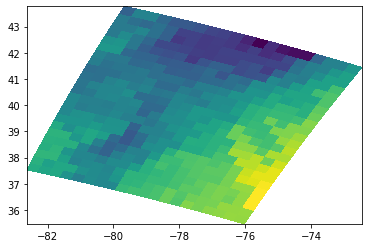

In [91]:
plt.pcolor(long_subset, lat_subset, airsubset[0,:,:])

In [109]:
# find the time indices in the NARR timeseries corresponding to CMC and CBP measurements

# make a dataframe and make the narr timestamps the index
narrtdf=pd.DataFrame({'Datetime':pd.DatetimeIndex(time_narr_import)})
narrtdf=narrtdf.set_index('Datetime')

# make a new empty array for the time indices
narr_tind=np.array([],dtype=int) 

for i in range(len(daterange)):
  ttmp=daterange[i]
  #if CMC/CBP data are newer than the last timestamp for NARR data
  if (pd.to_datetime(ttmp)>narrtdf.index[-1]): 
    tmpind=-1
  else:
    tmpind=narrtdf.index.get_loc(ttmp,method='bfill')
  narr_tind=np.append(narr_tind,tmpind)
  
# save narr_tind as integer 
narr_tind=narr_tind.astype(int)

In [126]:
# if CMC/CBP data are newer than April 2020, when the NARR data stops, 
# keep track of those indices so you can NaN the data later 
naninds=np.where(narr_tind==-1)

In [134]:

# first, combine the CMC and CBP coordinates and zip location data

#CMC and CBP coordinates 
allcoord = list(zip(loc_df.Latitude,loc_df.Longitude))

#NARR coordinates 
narrcoord = list(zip(np.ravel(lat_subset), np.ravel(long_subset)))

In [140]:
# then, find the closest NARR grid cell to the CMC and CBP coordinates 

# make a kdtree for the narr coordinates, then query it for the CMC/CBP coordinates
tree = KDTree(narrcoord)

# query and obtain corresponding climate data
narrxyid=tree.query(allcoord,k=1)

#get the matrix indices for the re-rolled matrix to correspond to the airtemp data
narrxy_ind1=(np.floor(narrxyid[1]/lat_subset.shape[1])).astype(int)
narrxy_ind2=(narrxyid[1]-narrxy_ind1*lat_subset.shape[1]).astype(int)

In [157]:
#check that the coordinates are close to each other 
h=9
print(allcoord[h],narrcoord[narrxyid[1][h]])
lat_subset[narrxy_ind1[h],narrxy_ind2[h]],long_subset[narrxy_ind1[h],narrxy_ind2[h]]

(38.5583, -75.5696) (38.42746, -75.55963)


(38.42746, -75.55963)

In [158]:
all_data=pd.read_csv(os.path.join(PROJ_ROOT, 
                         'data',
                        'processed',
                         'lc_pol_merged_data.csv'), parse_dates=['new_date'])

C:\Users\Bryan\Anaconda3\envs\hacktb\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,7,8,9,10,11,14,15,16,17,18,19,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [159]:
# extract air temp and convert kelvin to celsius
# nan the data that's too recent
narr_data_airtemp=airsubset[narr_tind,narrxy_ind1,narrxy_ind2]-273.15
narr_data_airtemp[naninds]=np.nan

In [162]:
var_data.keys()

dict_keys(['apcp', 'uwnd', 'vwnd', 'rhum', 'lcdc', 'ssrun', 'air'])

In [167]:
var_data_subset = defaultdict(lambda: 'Not Present')

In [168]:
for varname, varsubset in var_data.items():
    tmp = varsubset[narr_tind,narrxy_ind1,narrxy_ind2]
    tmp[naninds]=np.nan
    var_data_subset[varname]=tmp
    

In [169]:
# over the 24 and 48 hours before the sampling event
hr24=narr_tind-8
hr48=narr_tind-16
print(time_narr_import[hr48[0]],time_narr_import[hr24[0]],time_narr_import[narr_tind[0]])

2019-03-22 15:00:00 2019-03-23 15:00:00 2019-03-24 15:00:00


In [196]:
# add up the cumulative precipitation 24 hours before the sampling event 
tmp=var_data['apcp'][hr24,narrxy_ind1,narrxy_ind2]

for i in range(1,8):
  #print(time_narr_import[hr24[0]+i])
  tmp=np.vstack((tmp,var_data['apcp'][(hr24+i),narrxy_ind1,narrxy_ind2]))

narr_precip24=np.sum(tmp,axis=0)

In [198]:
# add up the cumulative precipitation 48 hours before the sampling event 
tmp=var_data['apcp'][hr48,narrxy_ind1,narrxy_ind2]

for i in range(1,16):
  #print(time_narr_import[hr48[0]+i])
  tmp=np.vstack((tmp,var_data['apcp'][(hr24+i),narrxy_ind1,narrxy_ind2]))

narr_precip48=np.sum(tmp,axis=0)

In [199]:
#nan the naninds for the precip24, precip48 variables
narr_precip24[naninds]=np.nan
narr_precip48[naninds]=np.nan

In [213]:
# var_data_subset['air'] = var_data_subset['air'] - 273
# var_data_subset['air'] = var_data_subset['air'] - .15

In [217]:
narr_windspeed = np.sqrt(var_data_subset['uwnd']**2 +var_data_subset['vwnd']**2)
narr_dir= 270-(np.arctan(-var_data_subset['vwnd'],var_data_subset['uwnd'])*57.29578)

In [220]:
narr_data = pd.concat([pd.DataFrame(data=narr_data_airtemp,columns=['airtemp_narr']),
                          pd.DataFrame(data=var_data_subset['apcp'],columns=['precip3_narr']),
                          pd.DataFrame(data=var_data_subset['rhum'],columns=['humidity_narr']),
                          pd.DataFrame(data=var_data_subset['lcdc'],columns=['cl_cover_narr']),
                          pd.DataFrame(data=var_data_subset['ssrun'],columns=['sfc_runoff']),
                          pd.DataFrame(data=var_data_subset['air'],columns=['sfc_air_narr']),
                          pd.DataFrame(data=var_data_subset['uwnd'],columns=['u_wind_narr']),
                          pd.DataFrame(data=var_data_subset['vwnd'],columns=['v_wind_narr']),
                          pd.DataFrame(data=narr_windspeed,columns=['windspeed_narr']),
                          pd.DataFrame(data=narr_dir,columns=['wdirection_narr']),
                          pd.DataFrame(data=narr_precip24,columns=['precip24_narr']),
                          pd.DataFrame(data=narr_precip48,columns=['precip48_narr'])], axis=1)

In [221]:
narr_data

,airtemp_narr,precip3_narr,humidity_narr,cl_cover_narr,sfc_runoff,sfc_air_narr,u_wind_narr,v_wind_narr,windspeed_narr,wdirection_narr,precip24_narr,precip48_narr
0,10.475159,0.0,50.314972,0.0,0.0,15.950953,-0.871403,1.188705,2.768492,319.927734,0.000631,0.000631
1,10.475159,0.0,50.314972,0.0,0.0,15.950953,-0.732618,0.899643,4.375051,311.975891,0.000631,0.000631
2,10.475159,0.0,50.314972,0.0,0.0,15.950953,-0.871403,1.188705,2.768492,319.927734,0.000631,0.000631
3,13.404327,0.0,43.768684,0.0,0.0,18.271509,-1.326357,4.009186,4.656967,345.994659,0.000631,0.008444
4,13.404327,0.0,43.768684,0.0,0.0,18.271509,-1.326357,4.009186,4.656967,345.994659,0.000631,0.008444
...,...,...,...,...,...,...,...,...,...,...,...,...
103290,5.855164,0.0,87.959641,57.0,0.0,5.420373,1.316453,-3.846542,3.906379,194.572815,0.046875,0.046875
103291,2.192596,0.0,91.256569,0.0,0.0,0.761987,1.268207,-3.203323,3.425949,197.337097,1.056926,7.525676
103292,-1.641449,0.0,96.074768,2.0,0.0,-2.319617,0.959544,-1.426971,1.968258,215.022186,0.039062,3.500000
103293,4.546539,0.0,93.312500,0.0,0.0,3.260034,-1.004335,1.572357,3.312654,327.544128,0.000000,0.000000


In [222]:
narr_data.shape

(103295, 12)

In [223]:
all_data.shape

(103295, 58)

In [224]:
total_df = pd.concat([all_data, narr_data], axis=1)

In [227]:
total_df.head()

,new_date,CloudCover,GaugeHeight,GroupCode,HUC12,Latitude,Longitude,Method,Other Conditions,Rainfall,...,humidity_narr,cl_cover_narr,sfc_runoff,sfc_air_narr,u_wind_narr,v_wind_narr,windspeed_narr,wdirection_narr,precip24_narr,precip48_narr
0,2019-03-24 12:28:00,NaN,NaN,NWA,NaN,38.6336,-75.6177,NaN,NaN,NaN,...,50.314972,0.0,0.0,15.950953,-0.871403,1.188705,2.768492,319.927734,0.000631,0.000631
1,2019-03-24 12:46:00,NaN,NaN,NWA,NaN,38.6422,-75.6068,NaN,NaN,NaN,...,50.314972,0.0,0.0,15.950953,-0.732618,0.899643,4.375051,311.975891,0.000631,0.000631
2,2019-03-24 13:05:00,NaN,NaN,NWA,NaN,38.6013,-75.6563,NaN,NaN,NaN,...,50.314972,0.0,0.0,15.950953,-0.871403,1.188705,2.768492,319.927734,0.000631,0.000631
3,2019-03-24 15:20:00,NaN,NaN,NWA,NaN,38.5645,-75.6723,NaN,NaN,NaN,...,43.768684,0.0,0.0,18.271509,-1.326357,4.009186,4.656967,345.994659,0.000631,0.008444
4,2019-03-24 15:34:00,NaN,NaN,NWA,NaN,38.5583,-75.5696,NaN,NaN,NaN,...,43.768684,0.0,0.0,18.271509,-1.326357,4.009186,4.656967,345.994659,0.000631,0.008444


In [228]:
total_df.columns

Index(['new_date', 'CloudCover', 'GaugeHeight', 'GroupCode', 'HUC12',
       'Latitude', 'Longitude', 'Method', 'Other Conditions', 'Rainfall',
       'Rainfall Within 24 Hours', 'Rainfall Within 48 Hours', 'SampleDepth',
       'SampleId', 'Station', 'StationCode', 'StationName',
       'Weather Conditions Day Before Yesterday', 'Weather Conditions Today',
       'Weather Conditions Yesterday', 'WindDirection', 'WindSpeed', 'state',
       'HUC12_', 'HUCNAME_', 'FIPS_', 'COUNTY_', 'STATE_', 'areaacres',
       'states', 'huc12', 'za_mean', 'lc_0', 'lc_11', 'lc_21', 'lc_22',
       'lc_23', 'lc_24', 'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71',
       'lc_81', 'lc_82', 'lc_90', 'lc_95', 'month', 'year', 'week',
       'dayofweek', 'hour', 'min', 'quarter', 'DO', 'TN', 'TP', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'preci

In [238]:
total_df[total_df.new_date.map(lambda x: x.month)==6][['new_date','airtemp_narr','sfc_air_narr']]

,new_date,airtemp_narr,sfc_air_narr
128,2019-06-02 15:08:00,29.172485,33.695457
129,2019-06-02 15:50:00,29.172485,33.695457
130,2019-06-02 18:07:00,28.540924,29.164942
131,2019-06-02 18:32:00,28.540924,29.164942
132,2019-06-02 18:50:00,28.540924,29.164942
...,...,...,...
103252,2016-06-14 09:05:00,21.633698,23.593836
103263,2018-06-13 08:45:00,20.713531,20.321924
103265,2018-06-05 08:00:00,18.267242,17.312037
103273,2016-06-09 08:15:00,13.088043,11.461084


In [240]:
total_df.to_csv(os.path.join(PROJ_ROOT, 
                         'data',
                        'processed',
                'narr_data.csv'), index=False)